In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/person-in-bed-streaming-detection/sample_submission.csv
/kaggle/input/person-in-bed-streaming-detection/train.json
/kaggle/input/person-in-bed-streaming-detection/License Agreement.pdf
/kaggle/input/person-in-bed-streaming-detection/test.json


# Read csv file

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft, fftfreq
import pywt
from joblib import load  # For loading trained model

with open('/kaggle/input/person-in-bed-streaming-detection/train.json', 'r') as f:
    data = json.load(f)


df = pd.DataFrame(data)
df.shape

(33, 4)

# Split the dataset into train n test dfs

In [4]:
# Split the DataFrame
df1 = df.iloc[:24]  # First 24 rows
df2 = df.iloc[24:]  # Remaining rows

In [4]:
len(data),type(data)
data1 = data[:24]
data2 = data[24:]
print(len(data2))

9


In [10]:
import json
import numpy as np
from scipy.signal import butter, filtfilt

# Define a function to create a low-pass Butterworth filter
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply the low-pass filter to data
def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

# Function to process a single subject
def process_subject(subject_data, cutoff_freq=15.0, sampling_rate=250):
    # Extract accelerometer data and timestamps
    accel_data = np.array(subject_data['accel'])
    ts_data = np.array(subject_data['ts'])
    
    # Apply low-pass filter to each axis (x, y, z)
    filtered_accel = np.array([butter_lowpass_filter(accel_data[:, i], cutoff_freq, sampling_rate) for i in range(3)]).T
    
    # Return processed subject data without downsampling
    return {
        'subject': subject_data['subject'],
        'accel': filtered_accel.tolist(),
        'ts': ts_data.tolist(),
        'labels': subject_data['labels']  # Keep original labels
    }

# Load the JSON file
with open('/kaggle/input/person-in-bed-streaming-detection/train.json', 'r') as f:
    data = json.load(f)

# Process each subject independently
processed_data = [process_subject(subject_data) for subject_data in data]

# Save the processed data back to JSON
with open('LowPass_train.json', 'w') as f:
    json.dump(processed_data, f)

print("Low-pass filtering (15 Hz) complete without downsampling.")

Low-pass filtering (15 Hz) complete without downsampling.


In [3]:
import json
import numpy as np
from scipy.signal import butter, filtfilt

# Load data from train.json or test.json
with open('/kaggle/input/person-in-bed-streaming-detection/train.json') as f:
    data = json.load(f)

# Define a function to apply a low-pass filter with a cutoff of 15 Hz
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency is half the sampling rate
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

# Function to process each sample
def process_sample(sample, cutoff_freq=15.0, sampling_rate=250, downsample_factor=8):
    # Extract accelerometer data and timestamps
    accel_data = np.array(sample['accel'])
    ts_data = np.array(sample['ts'])

    # Apply low-pass filter to each axis of accelerometer data (x, y, z)
    filtered_accel = np.array([butter_lowpass_filter(accel_data[:, i], cutoff_freq, sampling_rate) for i in range(3)]).T
    
    # Downsample by selecting every nth value (downsample_factor)
    downsampled_accel = filtered_accel[::downsample_factor]
    downsampled_ts = ts_data[::downsample_factor]
    downsampled_labels = sample['labels'][::downsample_factor]
    
    # Return processed sample with filtered and downsampled data
    return {
        'subject': sample['subject'],
        'accel': downsampled_accel.tolist(),
        'ts': downsampled_ts.tolist(),
        'labels': downsampled_labels # Include downsampled labels
    }

# Apply processing to all samples in the dataset
processed_data = [process_sample(sample) for sample in data]

# Save the processed data (you can save it back to JSON or further process it)
with open('processed_train.json', 'w') as f:
    json.dump(processed_data, f)

print("Low-pass filtering (15 Hz) and downsampling (8x) complete.")

Low-pass filtering (15 Hz) and downsampling (8x) complete.


In [8]:
print(df.columns,df.shape)
len(df['ts'][0])
df.head()

Index(['subject', 'accel', 'ts', 'labels'], dtype='object') (33, 4)


,subject,accel,ts,labels
0,6,"[[-104.45370483398438, -47.076900482177734, 99...","[1725413045.9539144, 1725413045.957938, 172541...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,8,"[[-35.80979919433594, 4.746300220489502, 1004....","[1725485145.87179, 1725485145.87579, 172548514...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,9,"[[-127.514404296875, -219.5738983154297, 972.1...","[1725486115.209703, 1725486115.213703, 1725486...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,13,"[[-81.03810119628906, 159.6074981689453, 988.8...","[1725495163.050122, 1725495163.054122, 1725495...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,14,"[[-53.62110137939453, 11.957399368286133, 1004...","[1725496295.676547, 1725496295.680547, 1725496...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
df.head()
df.iloc[0]
print(df.iloc[0]['accel'][:3])
print(df.iloc[0]['ts'][:3])
df.iloc[0]['labels'][:3]

[[-104.45370483398438, -47.076900482177734, 999.4334716796875], [-104.16510009765625, -46.83510208129883, 999.4373779296875], [-104.31330108642578, -46.4567985534668, 999.6168823242188]]
[1725413045.9539144, 1725413045.957938, 1725413045.9619613]


[1, 1, 1]

In [5]:
accel = df.iloc[0]['accel']
print(accel[:5])
ax = [row[0] for row in accel]
print(len(ax),ax[:5])

[[-104.45370483398438, -47.076900482177734, 999.4334716796875], [-104.16510009765625, -46.83510208129883, 999.4373779296875], [-104.31330108642578, -46.4567985534668, 999.6168823242188], [-104.31330108642578, -46.410003662109375, 999.6284790039062], [-104.11830139160156, -46.101898193359375, 999.4179077148438]]
225406 [-104.45370483398438, -104.16510009765625, -104.31330108642578, -104.31330108642578, -104.11830139160156]


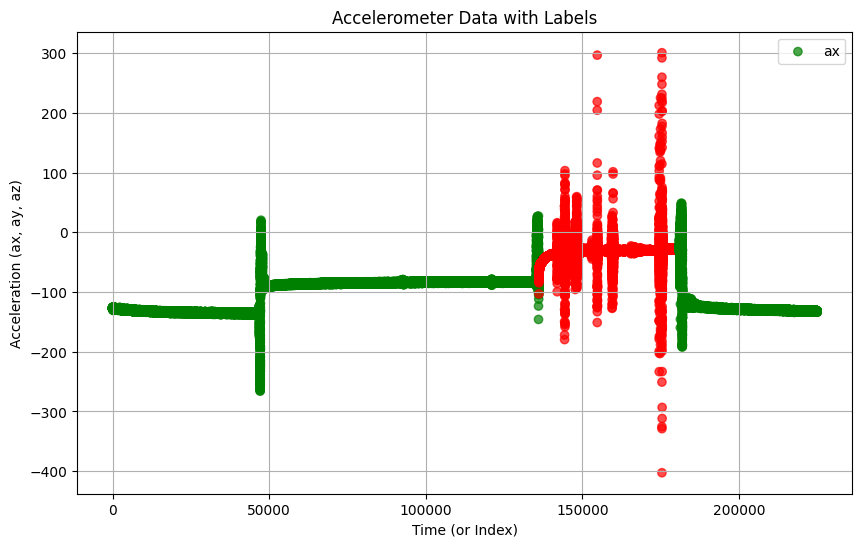

In [6]:
import numpy as np
import matplotlib.pyplot as plt

accel_data = df.iloc[2]['accel']  # 1000 readings for [ax, ay, az]
ts = df.iloc[2]['ts']    # Simulated time axis (replace with actual time data)
labels = df.iloc[2]['labels'] # Random binary labels (0 for not in bed, 1 for in bed)

# Extract ax, ay, az values
ax = [row[0] for row in accel_data]
ay = [row[1] for row in accel_data]
az = [row[2] for row in accel_data]

# Convert ts (if necessary) to a simple range (for x-axis plotting) or use the actual time axis
time_axis = range(len(ax))

# Create a color map where 0 is one color (e.g., red for 'not in bed') and 1 is another (e.g., green for 'in bed')
colors = ['red' if label == 0 else 'green' for label in labels]

# Create a plot for ax, ay, az values with color-coded points
plt.figure(figsize=(10, 6))

# Plot ax values
plt.scatter(time_axis, ax, c=colors, label='ax', alpha=0.7)

# Plot ay values
# plt.scatter(time_axis, ay, c=colors, label='ay', marker='x', alpha=0.7)

# Plot az values
# plt.scatter(time_axis, az, c=colors, label='az', marker='s', alpha=0.7)

# Labeling the plot
plt.title("Accelerometer Data with Labels")
plt.xlabel("Time (or Index)")
plt.ylabel("Acceleration (ax, ay, az)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


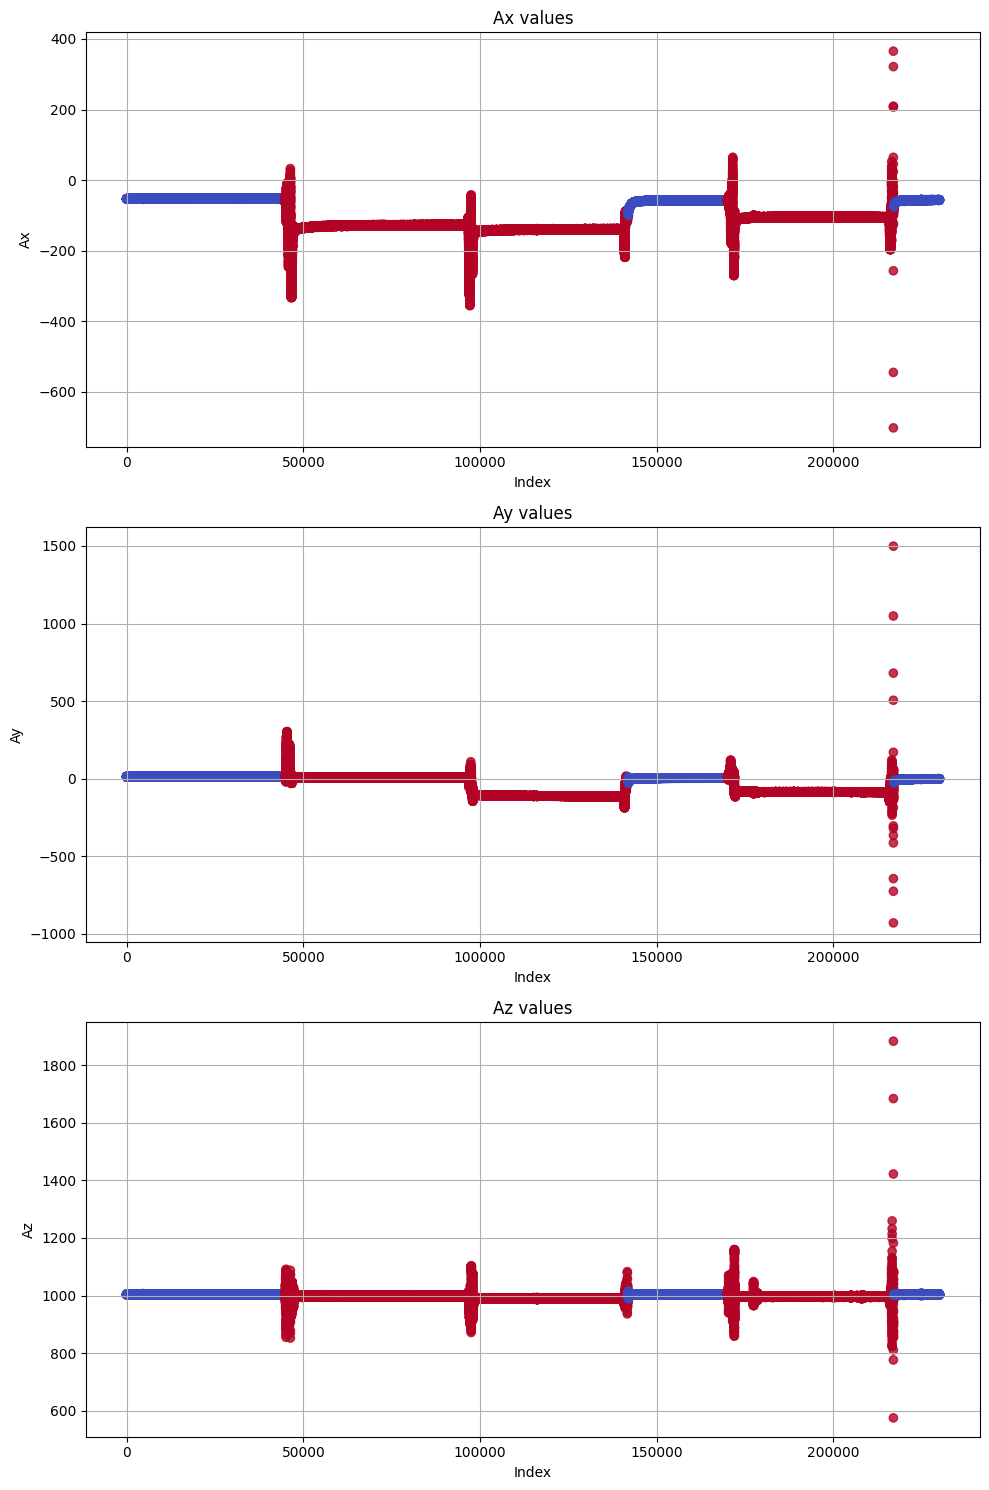

In [12]:
val = 4
accel_data = df.iloc[val]['accel']  # 1000 readings for [ax, ay, az]
ts = df.iloc[val]['ts']    # Simulated time axis (replace with actual time data)
labels = df.iloc[val]['labels'] # Random binary labels (0 for not in bed, 1 for in bed)

# Extract ax, ay, az values
ax = [row[0] for row in accel_data]
ay = [row[1] for row in accel_data]
az = [row[2] for row in accel_data]

# Convert to numpy arrays for easier handling
ax = np.array(ax)
ay = np.array(ay)
az = np.array(az)
labels = np.array(labels)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 rows, 1 column of subplots

# Plot ax
axes[0].scatter(range(len(ax)), ax, c=labels, cmap='coolwarm', alpha=0.8)
axes[0].set_title('Ax values')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Ax')
axes[0].grid(True)

# Plot ay
axes[1].scatter(range(len(ay)), ay, c=labels, cmap='coolwarm', alpha=0.8)
axes[1].set_title('Ay values')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Ay')
axes[1].grid(True)

# Plot az
axes[2].scatter(range(len(az)), az, c=labels, cmap='coolwarm', alpha=0.8)
axes[2].set_title('Az values')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Az')
axes[2].grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout so labels don't overlap
plt.show()

## Visualize amplitude Vs index

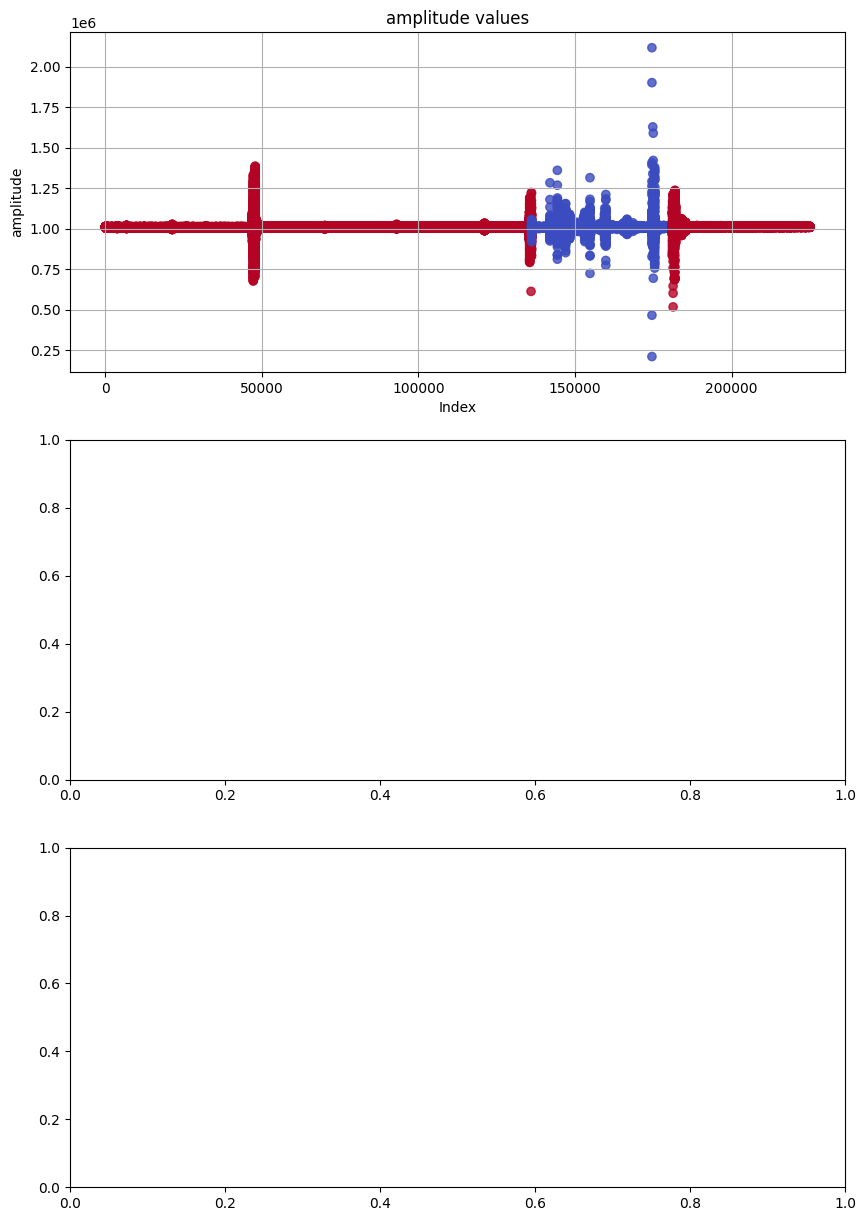

In [10]:
import numpy as np
import matplotlib.pyplot as plt
val = 2
accel_data = df.iloc[val]['accel']  # 1000 readings for [ax, ay, az]
ts = df.iloc[val]['ts']    # Simulated time axis (replace with actual time data)
labels = df.iloc[val]['labels'] # Random binary labels (0 for not in bed, 1 for in bed)

# Extract ax, ay, az values
ax = [row[0] for row in accel_data]
ay = [row[1] for row in accel_data]
az = [row[2] for row in accel_data]

# Convert ts (if necessary) to a simple range (for x-axis plotting) or use the actual time axis
time_axis = range(len(ax))

# Convert to numpy arrays for easier handling
ax = np.array(ax)
ay = np.array(ay)
az = np.array(az)
labels = np.array(labels)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 rows, 1 column of subplots

# Plot ax
axes[0].scatter(range(len(ax)), ax**2+ay**2+ az**2, c=labels, cmap='coolwarm', alpha=0.8)
axes[0].set_title('amplitude values')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('amplitude')
axes[0].grid(True)

## CNN

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Assuming your DataFrame is named df
# df.columns = ["subject", "accel", "ts", "labels"]

# Step 1: Extract the relevant columns
accel_data = df["accel"].tolist()  # List of 3-axis accelerometer readings
labels = df["labels"].tolist()  # List of corresponding labels
n_features = 3  # ax, ay, az

# Step 2: Create non-overlapping windows (segments)
time_steps = 1  # Window size

def create_windows(accel_data, labels, time_steps):
    X = []
    y = []
    for i in range(len(accel_data)):
        subject_accel = accel_data[i]  # Get the accelerometer data for the subject
        subject_labels = labels[i]  # Get the labels for the subject
        
        # Create windows of size `time_steps`
        for j in range(0, len(subject_accel) - time_steps + 1, time_steps):
            X.append(subject_accel[j:j + time_steps])  # 3-axis accel data for this window
            # Majority voting for labels within the window
            y.append(np.bincount(subject_labels[j:j + time_steps]).argmax())
    
    return np.array(X), np.array(y)

# Create windows for the entire dataset
X, y = create_windows(accel_data, labels, time_steps)

# Step 3: Normalize the accelerometer data
scaler = StandardScaler()
X_reshaped = X.reshape(-1, n_features)  # Flatten for normalization
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(-1, time_steps, n_features)  # Reshape back

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Define the CNN model
model = tf.keras.Sequential()

# 1D Convolutional layers
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, n_features)))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# Flatten and Dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))

# Output layer for binary classification (0 or 1)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Step 6: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Computed output size would be negative. Received `inputs shape=(None, 1, 3)`, `kernel shape=(3, 3, 64)`, `dilation_rate=[1]`.

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import MaxPooling1D, Dropout

# Step 1: Assuming df is your DataFrame with 'accel' and 'labels' columns
accel_data = []
labels = []

# Extract accel and labels data from the DataFrame
for i in range(len(df)):
    accel_data.extend(df['accel'].iloc[i])  # Extract all accelerometer readings (ax, ay, az)
    labels.extend(df['labels'].iloc[i])  # Extract corresponding labels (0 or 1)

# Convert to numpy arrays for ease of manipulation
accel_data = np.array(accel_data)  # Shape: (total_samples, 3)
labels = np.array(labels)  # Shape: (total_samples,)

# Step 2: Preprocessing - Standardize the accelerometer data
scaler = StandardScaler()
accel_data = scaler.fit_transform(accel_data)

# Step 3: Train-test split (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(accel_data, labels, test_size=0.2, random_state=42)
n_samples = len(accel_data)

# Define the split point (80% train, 20% test)
split_point = int(0.8 * n_samples)

# First 80% of the data is for training
X_train = accel_data[:split_point]
y_train = labels[:split_point]

# Last 20% of the data is for testing
X_test = accel_data[split_point:]
y_test = labels[split_point:]

# Step 4: Build the CNN model
model = Sequential()

# Add 1D Convolutional layers
# model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(3, 1)))
# model.add(Flatten())  # Flatten to feed into the dense layer
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification (0 or 1)

# Step 8: Build the CNN model
model = Sequential()

# Add 1D Convolutional layers with 'same' padding
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=(3, 1)))
# Removing pooling layer to prevent dimension reduction issues
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'))
# Removing pooling layer to prevent dimension reduction issues
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




# Step 9: Train the model on the first 80% of data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Step 10: Evaluate the model on the last 20% of data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')


# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Reshape the data to (n_samples, 3, 1) since Conv1D expects a 3D input
# X_train_reshaped = X_train.reshape(-1, 3, 1)
# X_test_reshaped = X_test.reshape(-1, 3, 1)

# # Step 5: Train the model
# model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_data=(X_test_reshaped, y_test))

# # Step 6: Evaluate the model
# loss, accuracy = model.evaluate(X_test_reshaped, y_test)
# print(f'Test Accuracy: {accuracy*100:.2f}%')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1729666557.706061     102 service.cc:145] XLA service 0x7db41800da10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729666557.706104     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729666557.706110     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


    87/191734 ━━━━━━━━━━━━━━━━━━━━ 5:37 2ms/step - accuracy: 0.6350 - loss: 0.5686

I0000 00:00:1729666565.087427     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191734/191734 ━━━━━━━━━━━━━━━━━━━━ 395s 2ms/step - accuracy: 0.9619 - loss: 0.1146 - val_accuracy: 0.6034 - val_loss: 0.9858
Epoch 2/10
191734/191734 ━━━━━━━━━━━━━━━━━━━━ 382s 2ms/step - accuracy: 0.9749 - loss: 0.0845 - val_accuracy: 0.5965 - val_loss: 1.1491
Epoch 3/10
191734/191734 ━━━━━━━━━━━━━━━━━━━━ 391s 2ms/step - accuracy: 0.9749 - loss: 0.0860 - val_accuracy: 0.5995 - val_loss: 1.0585
Epoch 4/10
191734/191734 ━━━━━━━━━━━━━━━━━━━━ 389s 2ms/step - accuracy: 0.9749 - loss: 0.0869 - val_accuracy: 0.6036 - val_loss: 1.0022
Epoch 5/10
191734/191734 ━━━━━━━━━━━━━━━━━━━━ 383s 2ms/step - accuracy: 0.9745 - loss: 0.0878 - val_accuracy: 0.5924 - val_loss: 1.1671
Epoch 6/10
191734/191734 ━━━━━━━━━━━━━━━━━━━━ 387s 2ms/step - accuracy: 0.9740 - loss: 0.0891 - val_accuracy: 0.7515 - val_loss: 0.8713
Epoch 7/10
191734/191734 ━━━━━━━━━━━━━━━━━━━━ 384s 2ms/step - accuracy: 0.9740 - loss: 0.0902 - val_accuracy: 0.8233 - val_loss: 0.8173
Epoch 8/10
191734/191734 ━━━━━━━━━━━━━━━━━━━━ 382s 2ms/step

## GMM

In [9]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Assuming 'df' is your DataFrame with columns 'accel', 'ts', and 'labels'
selected_indices = [0]
# Step 1: Prepare the data for GMM
def prepare_data(df):
    accel_data = []
    true_labels = []

    for i, row in df.iterrows():
        if i in selected_indices:
            subject_accel = np.array(row['accel'])  # Get 3-axis accelerometer data for the subject
            accel_data.append(subject_accel)  # Append accel data (3D)
            true_labels.extend(row['labels'])  # Append all labels (0 or 1) for the subject

    # Convert list to numpy array and reshape for GMM
    accel_data = np.vstack(accel_data)  # Combine into a single 2D array of shape (n_samples, 3)
    true_labels = np.array(true_labels)  # Convert to a numpy array

    return accel_data, true_labels

# Prepare the accelerometer data and labels
accel_data, true_labels = prepare_data(df)

# Step 2: Scale the data (GMM performs better when features are scaled)
scaler = StandardScaler()
accel_data_scaled = scaler.fit_transform(accel_data)

# Step 3: Train a Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=2, random_state=42)  # n_components=2 for binary classification
gmm.fit(accel_data_scaled)

# Step 4: Predict the labels (0 or 1) based on the GMM
gmm_labels = gmm.predict(accel_data_scaled)

# Since GMM assigns clusters, we need to map them to the actual labels.
# We'll compare with the true labels to determine the correct mapping
if accuracy_score(true_labels, gmm_labels) < accuracy_score(true_labels, 1 - gmm_labels):
    gmm_labels = 1 - gmm_labels  # Flip the labels if needed

# Step 5: Evaluate the accuracy of GMM predictions
accuracy = accuracy_score(true_labels, gmm_labels)
print(f"GMM Accuracy: {accuracy * 100:.2f}%")

# Now, `gmm_labels` contains the predicted "in bed" (1) or "not in bed" (0) labels.


GMM Accuracy: 62.31%


## 

In [17]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame containing 'accel', 'ts', 'labels'
selected_indices = [16]
# Function to calculate baseline statistics for each subject's accelerometer data
def calculate_baseline_stats(df):
    stats = []

    for i, row in df.iterrows():
        if i in selected_indices:
            subject = row['subject']
            accel_data = np.array(row['accel'])  # Convert to numpy array for easier calculations
    
            # Separate ax, ay, az
            ax = accel_data[:, 0]  # X-axis data
            ay = accel_data[:, 1]  # Y-axis data
            az = accel_data[:, 2]  # Z-axis data
    
            # Calculate statistics for each axis
            stats.append({
                'subject': subject,
                'ax_mean': np.mean(ax),
                'ay_mean': np.mean(ay),
                'az_mean': np.mean(az),
                'ax_std': np.std(ax),
                'ay_std': np.std(ay),
                'az_std': np.std(az),
                'ax_min': np.min(ax),
                'ay_min': np.min(ay),
                'az_min': np.min(az),
                'ax_max': np.max(ax),
                'ay_max': np.max(ay),
                'az_max': np.max(az),
                'ax_median': np.median(ax),
                'ay_median': np.median(ay),
                'az_median': np.median(az)
            })

    # Convert list of dicts to a DataFrame for easy interpretation
    stats_df = pd.DataFrame(stats)
    return stats_df

# Call the function to calculate baseline statistics
baseline_stats_df = calculate_baseline_stats(df)

# Display the results
print(baseline_stats_df)


   subject    ax_mean   ay_mean      az_mean     ax_std     ay_std     az_std  \
0      105 -20.295093 -2.233014  1004.539571  12.173785  27.099128  15.416213   

       ax_min      ay_min      az_min      ax_max      ay_max       az_max  \
0 -426.102295 -277.095032 -883.166687  382.746002  335.314178  2044.719238   

   ax_median  ay_median    az_median  
0 -24.663599    -19.344  1004.538513  


   subject   ax_mean    ay_mean     az_mean    ax_std     ay_std     az_std  \
0        6 -97.62978 -27.014011  1000.59057  6.983543  13.755048  11.714283   

       ax_min      ay_min     az_min      ax_max      ay_max       az_max  \
0 -444.607788 -361.136078 -1440.6521  694.648499  405.514191  2044.719238   

   ax_median  ay_median    az_median  
0 -97.706703   -34.1991  1000.654236






subject   ax_mean   ay_mean      az_mean     ax_std     ay_std    az_std  \
0        8 -3.433832  34.24448  1000.267771  31.393418  82.633972  8.636337   

      ax_min      ay_min      az_min     ax_max      ay_max       az_max  \
0 -88.377899 -187.508087  661.088989  91.880096  176.178604  1321.647705   

   ax_median  ay_median    az_median  
0   -14.2311     4.3524  1003.793701

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.

In [28]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Step 1: Assuming df is your DataFrame with 'accel' and 'labels' columns
accel_data = []
labels = []

# Extract accel and labels data from the DataFrame
for i in range(len(df)):
    accel_data.extend(df['accel'].iloc[i])  # Extract all accelerometer readings (ax, ay, az)
    labels.extend(df['labels'].iloc[i])  # Extract corresponding labels (0 or 1)

# Convert to numpy arrays for ease of manipulation
accel_data = np.array(accel_data)  # Shape: (total_samples, 3)
labels = np.array(labels)  # Shape: (total_samples,)


# Step 2: Define the window size for segmentation
window_size = 1

# Create windows and corresponding labels using majority voting
def create_windows(accel_data, labels, window_size):
    X = []
    y = []
    
    # Loop through data and create non-overlapping windows
    for i in range(0, len(accel_data) - window_size + 1, window_size):
        X.append(accel_data[i:i + window_size])  # Add a window of accel data
        # Perform majority voting for the labels in the window
        window_labels = labels[i:i + window_size]
        y.append(np.bincount(window_labels).argmax())  # Most frequent label in the window
    
    return np.array(X), np.array(y)

# Apply the segmentation function to the data
X_windowed, y_windowed = create_windows(accel_data, labels, window_size)

# Step 3: Preprocessing - Standardize the accelerometer data
scaler = StandardScaler()
X_windowed = scaler.fit_transform(X_windowed.reshape(-1, X_windowed.shape[-1])).reshape(X_windowed.shape)

# Step 4: Train-test split (80% train, 20% test)

# Time-series split

n_samples = len(X_windowed)
split_point = int(0.8 * n_samples)

X_train = X_windowed[:split_point]
y_train = y_windowed[:split_point]

X_test = X_windowed[split_point:]
y_test = y_windowed[split_point:]

# X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

# Step 5: Reshape the data to fit the CNN input requirements
# CNN expects input shape to be (samples, time steps, features), where time steps is window_size (e.g., 128)
X_train = X_train.reshape(X_train.shape[0], window_size, 3)
X_test = X_test.reshape(X_test.shape[0], window_size, 3)

# Step 6: Build the CNN model
model = Sequential()

# Add 1D Convolutional layers with 'same' padding
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=(window_size, 3)))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Step 7: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Step 9: Evaluate the model on the last 20% of data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Step 10: Predict labels for test data
y_pred = model.predict(X_test)

# Step 11: Map the predicted window labels back to the original rows
def map_predictions_to_rows(accel_data, window_size, y_pred):
    y_pred_for_rows = np.zeros(len(accel_data))
    
    for i in range(0, len(accel_data) - window_size + 1, window_size):
        y_pred_for_rows[i:i + window_size] = y_pred[i // window_size]
    
    return y_pred_for_rows

# Map the predicted labels back to the original test rows
y_pred_for_test_rows = map_predictions_to_rows(accel_data[split_point:], window_size, y_pred)

# Now you have predicted labels for the original rows!

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
191734/191734 ━━━━━━━━━━━━━━━━━━━━ 553s 3ms/step - accuracy: 0.9610 - loss: 0.1190 - val_accuracy: 0.6051 - val_loss: 1.1505
Epoch 2/10
  4138/191734 ━━━━━━━━━━━━━━━━━━━━ 7:54 3ms/step - accuracy: 0.9727 - loss: 0.0919

KeyboardInterrupt: 

In [25]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


# Step 1: Assuming df is your DataFrame with 'accel' and 'labels' columns
accel_data = []
labels = []

# Extract accel and labels data from the DataFrame
for i in range(len(df)):
    accel_data.extend(df['accel'].iloc[i])  # Extract all accelerometer readings (ax, ay, az)
    labels.extend(df['labels'].iloc[i])  # Extract corresponding labels (0 or 1)

# Convert to numpy arrays for ease of manipulation
accel_data = np.array(accel_data)  # Shape: (total_samples, 3)
labels = np.array(labels)  # Shape: (total_samples,)


# Step 2: Define the window size for segmentation
window_size = 1

# Create windows and corresponding labels using majority voting
def create_windows(accel_data, labels, window_size):
    X = []
    y = []
    
    # Loop through data and create non-overlapping windows
    for i in range(0, len(accel_data) - window_size + 1, window_size):
        X.append(accel_data[i:i + window_size])  # Add a window of accel data
        # Perform majority voting for the labels in the window
        window_labels = labels[i:i + window_size]
        y.append(np.bincount(window_labels).argmax())  # Most frequent label in the window
    
    return np.array(X), np.array(y)

# Apply the segmentation function to the data
X_windowed, y_windowed = create_windows(accel_data, labels, window_size)

# Step 3: Preprocessing - Standardize the accelerometer data
scaler = StandardScaler()

X_windowed = scaler.fit_transform(X_windowed.reshape(-1, X_windowed.shape[-1])).reshape(X_windowed.shape)

# Time-series split

n_samples = len(X_windowed)
split_point = int(0.8 * n_samples)

X_train = X_windowed[:split_point]
y_train = y_windowed[:split_point]

X_test = X_windowed[split_point:]
y_test = y_windowed[split_point:]

# Step 4: Train-test split (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

# Step 5: Reshape the data to fit the CNN input requirements
# CNN expects input shape to be (samples, time steps, features), where time steps is window_size (e.g., 128)
X_train = X_train.reshape(X_train.shape[0], window_size, 3)
X_test = X_test.reshape(X_test.shape[0], window_size, 3)


In [24]:
print(accel_data.shape,len(accel_data))
labels.shape,len(labels)

(7669325, 3) 7669325


((7669325,), 7669325)

In [19]:
print(X_windowed.shape,len(X_windowed))
print(X_train.shape,X_test.shape,len(X_train),len(X_test))
print(y_windowed.shape,len(y_windowed))
print(y_train.shape,y_test.shape,len(y_train),len(y_test))

(59916, 128, 3) 59916
(47932, 128, 3) (11984, 128, 3) 47932 11984
(59916,) 59916
(47932,) (11984,) 47932 11984


In [21]:
# X_train[:1]
y_train

array([0, 0, 1, ..., 0, 1, 1])

In [7]:
df.head()

,subject,accel,ts,labels
0,6,"[[-104.45370483398438, -47.076900482177734, 99...","[1725413045.9539144, 1725413045.957938, 172541...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,8,"[[-35.80979919433594, 4.746300220489502, 1004....","[1725485145.87179, 1725485145.87579, 172548514...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,9,"[[-127.514404296875, -219.5738983154297, 972.1...","[1725486115.209703, 1725486115.213703, 1725486...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,13,"[[-81.03810119628906, 159.6074981689453, 988.8...","[1725495163.050122, 1725495163.054122, 1725495...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,14,"[[-53.62110137939453, 11.957399368286133, 1004...","[1725496295.676547, 1725496295.680547, 1725496...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# FFT

In [22]:
import numpy as np
import pandas as pd
from scipy.stats import mode, skew, kurtosis

# Assume accelerometer data is sampled at 250 Hz
sampling_rate = 250  # samples per second
segment_duration = 5  # seconds
samples_per_segment = sampling_rate * segment_duration

# Modify the feature extraction function to operate on segments
def extract_periodic_features_segmented(accel_segment):
    x, y, z = accel_segment[:, 0], accel_segment[:, 1], accel_segment[:, 2]
    
    # Compute FFT
    fft_x = np.fft.fft(x)
    fft_y = np.fft.fft(y)
    fft_z = np.fft.fft(z)
    
    # Compute the frequency bins
    n = len(x)
    freqs = np.fft.fftfreq(n)
    
    # Calculate the amplitude spectrum
    amplitude_x = np.abs(fft_x)
    amplitude_y = np.abs(fft_y)
    amplitude_z = np.abs(fft_z)

    # Extract features (dominant frequency, mean, variance, etc.)
    dominant_freq_x = freqs[np.argmax(amplitude_x[1:n//2])]
    dominant_freq_y = freqs[np.argmax(amplitude_y[1:n//2])]
    dominant_freq_z = freqs[np.argmax(amplitude_z[1:n//2])]

    features = {
        'dominant_freq_x': dominant_freq_x,
        'dominant_freq_y': dominant_freq_y,
        'dominant_freq_z': dominant_freq_z,
        
        # Time-domain features
        'mean_x': np.mean(x),
        'mean_y': np.mean(y),
        'mean_z': np.mean(z),
        'std_dev_x': np.std(x),
        'std_dev_y': np.std(y),
        'std_dev_z': np.std(z),
        'variance_x': np.var(x),
        'variance_y': np.var(y),
        'variance_z': np.var(z),
        'skew_x': skew(x),
        'skew_y': skew(y),
        'skew_z': skew(z),
        'kurtosis_x': kurtosis(x),
        'kurtosis_y': kurtosis(y),
        'kurtosis_z': kurtosis(z),
        
        # Frequency-domain features: energy and power in frequency bands
        'energy_x': np.sum(amplitude_x**2),
        'energy_y': np.sum(amplitude_y**2),
        'energy_z': np.sum(amplitude_z**2),
        'power_x': np.mean(amplitude_x**2),
        'power_y': np.mean(amplitude_y**2),
        'power_z': np.mean(amplitude_z**2),
    }
    
    return features

# Apply segmentation and feature extraction
all_features = []

for _, row in df.iterrows():
    accel_data = np.array(row['accel'])
    labels_data = row['labels']
    
    # Split accel data and labels into 5-second segments
    num_segments = accel_data.shape[0] // samples_per_segment
    
    for i in range(num_segments):
        start = i * samples_per_segment
        end = start + samples_per_segment
        accel_segment = accel_data[start:end]
        labels_segment = labels_data[start:end]
        
        # Extract features from the segment
        features = extract_periodic_features_segmented(accel_segment)
        
        # Determine the majority label for the segment
        majority_label = mode(labels_segment).mode
        features['label'] = majority_label if majority_label.size > 0 else np.nan
        
        all_features.append(features)

# Convert the list of feature dictionaries to a DataFrame
features_df = pd.DataFrame(all_features)

print(features_df.head())
print(features_df.shape)



   dominant_freq_x  dominant_freq_y  dominant_freq_z      mean_x     mean_y  \
0           0.0440            0.000           0.0152 -103.334428 -45.073414   
1           0.0440            0.000           0.0360 -103.205332 -42.975460   
2           0.0368            0.000           0.0112 -103.157231 -41.658552   
3           0.0400            0.000           0.0200 -103.227799 -40.628409   
4           0.0112            0.044           0.0192 -103.326338 -39.795385   

       mean_z  std_dev_x  std_dev_y  std_dev_z  variance_x  ...  kurtosis_x  \
0  999.504229   0.430884   0.955938   0.329560    0.185661  ...    0.673629   
1  999.610445   0.321568   0.551717   0.278088    0.103406  ...    1.245693   
2  999.675564   0.311081   0.433445   0.310474    0.096771  ...    0.653917   
3  999.707874   0.373965   0.502038   0.363585    0.139850  ...    0.315603   
4  999.733533   0.399965   0.574744   0.352029    0.159972  ...    0.330623   

   kurtosis_y  kurtosis_z      energy_x      energ

In [23]:
features_df

,dominant_freq_x,dominant_freq_y,dominant_freq_z,mean_x,mean_y,mean_z,std_dev_x,std_dev_y,std_dev_z,variance_x,...,kurtosis_x,kurtosis_y,kurtosis_z,energy_x,energy_y,energy_z,power_x,power_y,power_z,label
0,0.0440,0.0000,0.0152,-103.334428,-45.073414,999.504229,0.430884,0.955938,0.329560,0.185661,...,0.673629,-0.679465,0.907384,1.668467e+10,3.175823e+09,1.560951e+12,1.334774e+07,2.540658e+06,1.248761e+09,1
1,0.0440,0.0000,0.0360,-103.205332,-42.975460,999.610445,0.321568,0.551717,0.278088,0.103406,...,1.245693,-0.378870,0.103308,1.664288e+10,2.886242e+09,1.561283e+12,1.331430e+07,2.308993e+06,1.249026e+09,1
2,0.0368,0.0000,0.0112,-103.157231,-41.658552,999.675564,0.311081,0.433445,0.310474,0.096771,...,0.653917,-0.198113,-0.046774,1.662736e+10,2.711911e+09,1.561486e+12,1.330189e+07,2.169529e+06,1.249189e+09,1
3,0.0400,0.0000,0.0200,-103.227799,-40.628409,999.707874,0.373965,0.502038,0.363585,0.139850,...,0.315603,-0.004017,0.281614,1.665018e+10,2.579562e+09,1.561587e+12,1.332015e+07,2.063650e+06,1.249270e+09,1
4,0.0112,0.0440,0.0192,-103.326338,-39.795385,999.733533,0.399965,0.574744,0.352029,0.159972,...,0.330623,0.335940,0.652851,1.668202e+10,2.475005e+09,1.561668e+12,1.334562e+07,1.980004e+06,1.249334e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6099,0.0840,0.0840,0.0840,82.406289,41.907356,989.252649,0.714658,0.897576,2.751801,0.510736,...,28.142193,8.705324,27.667602,1.061142e+10,2.745363e+09,1.529107e+12,8.489134e+06,2.196290e+06,1.223285e+09,0
6100,0.0808,0.0808,0.0808,82.404392,41.909076,989.243966,0.851016,1.261861,3.055095,0.724228,...,7.681837,2.725177,6.819730,1.061126e+10,2.746817e+09,1.529083e+12,8.489010e+06,2.197454e+06,1.223266e+09,0
6101,0.0216,0.0304,0.0496,82.337321,41.971575,989.263233,1.385035,3.907193,1.393101,1.918321,...,13.918929,40.540732,8.532095,1.059586e+10,2.776374e+09,1.529131e+12,8.476691e+06,2.221099e+06,1.223305e+09,0
6102,0.0208,0.0280,0.0216,82.430306,41.805747,989.237023,4.331156,5.756800,1.849358,18.758910,...,2.755475,6.659311,10.150185,1.064612e+10,2.782596e+09,1.529052e+12,8.516893e+06,2.226077e+06,1.223242e+09,0


In [26]:
import numpy as np
import pandas as pd
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assume accelerometer data is sampled at 250 Hz and we are working with the segment_duration of 5 seconds.
sampling_rate = 250  # samples per second
segment_duration = 5  # seconds
samples_per_segment = sampling_rate * segment_duration

# Function to extract features from a segment (already defined in the initial code)
def extract_periodic_features_segmented(accel_segment):
    x, y, z = accel_segment[:, 0], accel_segment[:, 1], accel_segment[:, 2]
    
    # Compute FFT
    fft_x = np.fft.fft(x)
    fft_y = np.fft.fft(y)
    fft_z = np.fft.fft(z)
    
    # Compute the frequency bins
    n = len(x)
    freqs = np.fft.fftfreq(n)

    # Calculate the amplitude spectrum
    amplitude_x = np.abs(fft_x)
    amplitude_y = np.abs(fft_y)
    amplitude_z = np.abs(fft_z)

    # Extract features (e.g., dominant frequency)
    dominant_freq_x = freqs[np.argmax(amplitude_x[1:n//2])]
    dominant_freq_y = freqs[np.argmax(amplitude_y[1:n//2])]
    dominant_freq_z = freqs[np.argmax(amplitude_z[1:n//2])]
    
    return {
        'dominant_freq_x': dominant_freq_x,
        'dominant_freq_y': dominant_freq_y,
        'dominant_freq_z': dominant_freq_z,
        'mean_x': np.mean(x),
        'mean_y': np.mean(y),
        'mean_z': np.mean(z),
    }

# Assuming df contains the data with accelerometer readings and labels
# Apply segmentation and feature extraction to the first 24 rows
all_features = []
all_labels = []

for _, row in df.iterrows():  # Iterate over the first 24 rows (subjects)
    accel_data = np.array(row['accel'])
    labels_data = row['labels']
    
    # Split accel data and labels into 5-second segments
    num_segments = accel_data.shape[0] // samples_per_segment
    
    for i in range(num_segments):
        start = i * samples_per_segment
        end = start + samples_per_segment
        accel_segment = accel_data[start:end]
        labels_segment = labels_data[start:end]
        
        # Extract features from the segment
        features = extract_periodic_features_segmented(accel_segment)
        
        # Determine the majority label for the segment
        majority_label = mode(labels_segment, axis=None).mode  # Access mode result correctly
        
        # For each row in the segment, assign the majority label
        for j in range(samples_per_segment):
            all_features.append(features)
            all_labels.append(majority_label)

# Convert the list of feature dictionaries to a DataFrame
features_df = pd.DataFrame(all_features)

# Create a new DataFrame with the corresponding labels for each timestep
labels_df = pd.DataFrame(all_labels, columns=['label'])

# Combine features and labels into a single DataFrame
final_df = pd.concat([features_df, labels_df], axis=1)

# Separate features and labels
X = final_df.drop(columns=['label'])  # Features
y = final_df['label']  # Labels

# Split the data into 80% training and 20% testing
train_size = int(0.8 * len(final_df))

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

# Train the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Make predictions on the test set
predictions = rfc.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy on the test set: {accuracy:.2f}")

print("Accuracy on test set:", accuracy)
print("Classification Report:\n", report)

Accuracy on the test set: 0.70


In [29]:
print("Accuracy on test set:", accuracy)
print("Classification Report:\n", report)

Accuracy on test set: 0.7018348623853211
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.44      0.61       596
           1       0.65      1.00      0.79       625

    accuracy                           0.73      1221
   macro avg       0.83      0.72      0.70      1221
weighted avg       0.82      0.73      0.70      1221



In [31]:
# Define latency scoring function
def latency_score(predictions, ground_truth, switch_indices, window_size=60, sampling_rate=250):
    samples_per_window = window_size * sampling_rate
    latency_scores = []
    accuracy_scores = []

    for switch_idx in switch_indices:
        # Define latency window
        start_idx = switch_idx
        end_idx = min(switch_idx + samples_per_window, len(predictions))
        latency_window_pred = predictions[start_idx:end_idx]
        latency_window_gt = y_test[start_idx:end_idx]

        # Accuracy within latency window
        s_acc_window = accuracy_score(latency_window_gt, latency_window_pred)

        # Heuristic to determine detection time
        for i in range(len(latency_window_pred)):
            if latency_window_pred[i] == latency_window_gt[i]:
                hold_duration = 15 * sampling_rate
                if np.all(latency_window_pred[i:i + hold_duration] == latency_window_gt[i]) and \
                        np.mean(latency_window_pred[i:]) >= 0.8:
                    detected_time_idx = start_idx + i
                    break
        else:
            detected_time_idx = end_idx

        # Calculate latency score
        t_switch_i = switch_idx
        t_hat_switch_i = detected_time_idx
        s_latency_i = np.exp(-2 * (np.log(1 - (t_hat_switch_i - t_switch_i) / samples_per_window)) ** 2)

        # Combine accuracy and latency scores
        s_switch_i = (s_acc_window + s_latency_i) / 2
        latency_scores.append(s_switch_i)
        accuracy_scores.append(s_acc_window)

    # General accuracy outside latency windows
    s_acc = accuracy_score(ground_truth.drop(switch_indices), predictions.drop(switch_indices))

    # Final score
    n_switch = len(switch_indices)
    total_score = s_acc + sum(latency_scores) / (n_switch + 1)

    print("General accuracy (s_acc):", s_acc)
    print("Latency scores for each switch (s_switch_i):", latency_scores)
    print("Total score (final evaluation metric):", total_score)

    return total_score

# Evaluate using the latency scoring function
total_score = latency_score(predictions, y_test, switch_indices)

NameError: name 'switch_indices' is not defined

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the 80/20 split point
split_point = int(0.8 * len(features_df))

# Split the data
train_df = features_df[:split_point]
test_df = features_df[split_point:]

# Separate features and labels for training and testing
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

Accuracy on test set: 0.7264537264537264
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.44      0.61       596
           1       0.65      1.00      0.79       625

    accuracy                           0.73      1221
   macro avg       0.83      0.72      0.70      1221
weighted avg       0.82      0.73      0.70      1221



In [ ]:
# Initialize and train the RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy on test set:", accuracy)
print("Classification Report:\n", report)

# Wavelet Transformation

In [20]:
import numpy as np
import pandas as pd
import pywt  # Import pywt for wavelet transformation
from scipy.stats import mode
import pywt
from scipy.stats import skew, kurtosis, entropy, mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assume accelerometer data is sampled at 250 Hz and we are working with a segment_duration of 5 seconds
sampling_rate = 250  # samples per second
segment_duration = 5  # seconds
samples_per_segment = sampling_rate * segment_duration

# Function to extract features from a segment using Wavelet Transformation
def extract_wavelet_features_segmented(accel_segment):
    x, y, z = accel_segment[:, 0], accel_segment[:, 1], accel_segment[:, 2]
    
    # Perform discrete wavelet transform for each axis
    coeffs_x = pywt.wavedec(x, 'db4', level=4)
    coeffs_y = pywt.wavedec(y, 'db4', level=4)
    coeffs_z = pywt.wavedec(z, 'db4', level=4)

    # Extract summary statistics from wavelet coefficients at each decomposition level
    def summarize_coeffs(coeffs):
        coeffs_entropy = entropy(np.abs(coeffs))
        return {
            'mean': np.mean(coeffs),
            'std': np.std(coeffs),
            'max': np.max(coeffs),
            'min': np.min(coeffs),
            'energy': np.sum(np.square(coeffs)),  # Energy
            'skewness': skew(coeffs),  # Skewness
            'kurtosis': kurtosis(coeffs),  # Kurtosis
            'median': np.median(coeffs),  # Median
            'iqr': np.percentile(coeffs, 75) - np.percentile(coeffs, 25),  # Interquartile Range (IQR)
            'entropy': coeffs_entropy  # Entropy
        }
#         return {
#             'mean': np.mean(coeffs),
#             'std': np.std(coeffs),
#             'max': np.max(coeffs),
#             'min': np.min(coeffs),
#         }

    features = {}
    for i, (cA_x, cD_x) in enumerate(zip(coeffs_x, coeffs_y)):
        features.update({
            f'cA_mean_x_level{i}': summarize_coeffs(cA_x)['mean'],
            f'cA_std_x_level{i}': summarize_coeffs(cA_x)['std'],
            f'cA_max_x_level{i}': summarize_coeffs(cA_x)['max'],
            f'cA_min_x_level{i}': summarize_coeffs(cA_x)['min'],
            
            
            # Repeat similar for y and z
        })
    
    return features

# Assuming df contains the data with accelerometer readings and labels
all_features = []
all_labels = []

for _, row in df.iterrows():  # Iterate over the rows
    accel_data = np.array(row['accel'])
    labels_data = row['labels']
    
    # Split accel data and labels into 5-second segments
    num_segments = accel_data.shape[0] // samples_per_segment
    
    for i in range(num_segments):
        start = i * samples_per_segment
        end = start + samples_per_segment
        accel_segment = accel_data[start:end]
        labels_segment = labels_data[start:end]
        
        # Extract wavelet features from the segment
        features = extract_wavelet_features_segmented(accel_segment)
        
        # Determine the majority label for the segment
        majority_label = mode(labels_segment, axis=None).mode
        
        # For each row in the segment, assign the majority label
        for j in range(samples_per_segment):
            all_features.append(features)
            all_labels.append(majority_label)

# Convert the list of feature dictionaries to a DataFrame
features_df = pd.DataFrame(all_features)

# Create a new DataFrame with the corresponding labels for each timestep
labels_df = pd.DataFrame(all_labels, columns=['label'])

# Combine features and labels into a single DataFrame
final_df = pd.concat([features_df, labels_df], axis=1)


KeyboardInterrupt



In [9]:
final_df.head()

,cA_mean_x_level0,cA_std_x_level0,cA_max_x_level0,cA_min_x_level0,cA_mean_x_level1,cA_std_x_level1,cA_max_x_level1,cA_min_x_level1,cA_mean_x_level2,cA_std_x_level2,...,cA_min_x_level2,cA_mean_x_level3,cA_std_x_level3,cA_max_x_level3,cA_min_x_level3,cA_mean_x_level4,cA_std_x_level4,cA_max_x_level4,cA_min_x_level4,label
0,-413.54235,1.39206,-411.072989,-418.893706,-0.136528,1.044232,2.180682,-3.007029,-0.014053,0.412796,...,-1.351174,-0.006827,0.15972,0.429593,-0.472455,-0.000927,0.122543,0.411718,-0.372185,1
1,-413.54235,1.39206,-411.072989,-418.893706,-0.136528,1.044232,2.180682,-3.007029,-0.014053,0.412796,...,-1.351174,-0.006827,0.15972,0.429593,-0.472455,-0.000927,0.122543,0.411718,-0.372185,1
2,-413.54235,1.39206,-411.072989,-418.893706,-0.136528,1.044232,2.180682,-3.007029,-0.014053,0.412796,...,-1.351174,-0.006827,0.15972,0.429593,-0.472455,-0.000927,0.122543,0.411718,-0.372185,1
3,-413.54235,1.39206,-411.072989,-418.893706,-0.136528,1.044232,2.180682,-3.007029,-0.014053,0.412796,...,-1.351174,-0.006827,0.15972,0.429593,-0.472455,-0.000927,0.122543,0.411718,-0.372185,1
4,-413.54235,1.39206,-411.072989,-418.893706,-0.136528,1.044232,2.180682,-3.007029,-0.014053,0.412796,...,-1.351174,-0.006827,0.15972,0.429593,-0.472455,-0.000927,0.122543,0.411718,-0.372185,1


In [ ]:
import numpy as np
import pandas as pd
import pywt
from scipy.stats import skew, kurtosis, entropy, mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assume accelerometer data is sampled at 250 Hz and we are working with a segment_duration of 5 seconds
sampling_rate = 250  # samples per second
segment_duration = 5  # seconds
samples_per_segment = sampling_rate * segment_duration

# # Function to extract features from a segment using Wavelet Transformation
# def extract_wavelet_features_segmented(accel_segment):
#     x, y, z = accel_segment[:, 0], accel_segment[:, 1], accel_segment[:, 2]
    
#     # Perform discrete wavelet transform for each axis
#     coeffs_x = pywt.wavedec(x, 'db4', level=7)
#     coeffs_y = pywt.wavedec(y, 'db4', level=7)
#     coeffs_z = pywt.wavedec(z, 'db4', level=7)

#     # Function to summarize wavelet coefficients with various metrics
#     def summarize_coeffs(coeffs):
#         coeffs_entropy = entropy(np.abs(coeffs))  # Entropy
#         return {
#             'mean': np.mean(coeffs),
#             'std': np.std(coeffs),
#             'max': np.max(coeffs),
#             'min': np.min(coeffs),
#             'energy': np.sum(np.square(coeffs)),  # Energy
#             'skewness': skew(coeffs),  # Skewness
#             'kurtosis': kurtosis(coeffs),  # Kurtosis
#             'median': np.median(coeffs),  # Median
#             'iqr': np.percentile(coeffs, 75) - np.percentile(coeffs, 25),  # Interquartile Range (IQR)
#             'entropy': coeffs_entropy  # Entropy
#         }

#     # Generate features dictionary
#     features = {}
#     for i, (cA_x, cA_y, cA_z) in enumerate(zip(coeffs_x, coeffs_y, coeffs_z)):
#         # Calculate features for each level and each axis
#         x_features = summarize_coeffs(cA_x)
#         y_features = summarize_coeffs(cA_y)
#         z_features = summarize_coeffs(cA_z)

#         # Update the dictionary with detailed features for each axis and level
#         for axis, axis_features in zip(['x', 'y', 'z'], [x_features, y_features, z_features]):
#             for feature_name, value in axis_features.items():
#                 features[f'cA_{feature_name}_{axis}_level{i}'] = value

#     return features


def extract_wavelet_features_segmented(accel_segment):
    x, y, z = accel_segment[:, 0], accel_segment[:, 1], accel_segment[:, 2]
    
    # Perform discrete wavelet transform for each axis
    coeffs_x = pywt.wavedec(x, 'db4', level=2)
    coeffs_y = pywt.wavedec(y, 'db4', level=2)
    coeffs_z = pywt.wavedec(z, 'db4', level=2)

    def summarize_coeffs(coeffs):
        coeffs_entropy = entropy(np.abs(coeffs))
        return {
            'mean': np.mean(coeffs),
            'std': np.std(coeffs),
            'max': np.max(coeffs),
            'min': np.min(coeffs),
            'energy': np.sum(np.square(coeffs)),
            'skewness': skew(coeffs),
            'kurtosis': kurtosis(coeffs),
            'median': np.median(coeffs),
            'iqr': np.percentile(coeffs, 75) - np.percentile(coeffs, 25),
            'entropy': coeffs_entropy
        }

    features = {}

    # Process approximation components (first element of each coeff list)
    for axis, coeffs in zip(['x', 'y', 'z'], [coeffs_x, coeffs_y, coeffs_z]):
        approx_features = summarize_coeffs(coeffs[0])
        for feature_name, value in approx_features.items():
            features[f'cA_{feature_name}_{axis}_level7'] = value

    # Process detail components (remaining elements of each coeff list)
    for level, (cD_x, cD_y, cD_z) in enumerate(zip(coeffs_x[1:], coeffs_y[1:], coeffs_z[1:]), start=1):
        for axis, cD in zip(['x', 'y', 'z'], [cD_x, cD_y, cD_z]):
def extract_wavelet_features_segmented(accel_segment):
    x, y, z = accel_segment[:, 0], accel_segment[:, 1], accel_segment[:, 2]
    
    # Perform discrete wavelet transform for each axis
    coeffs_x = pywt.wavedec(x, 'db4', level=2)
    coeffs_y = pywt.wavedec(y, 'db4', level=2)
    coeffs_z = pywt.wavedec(z, 'db4', level=2)

    def summarize_coeffs(coeffs):
        coeffs_entropy = entropy(np.abs(coeffs))
        return {
            'mean': np.mean(coeffs),
            'std': np.std(coeffs),
            'max': np.max(coeffs),
            'min': np.min(coeffs),
            'energy': np.sum(np.square(coeffs)),
            'skewness': skew(coeffs),
            'kurtosis': kurtosis(coeffs),
            'median': np.median(coeffs),
            'iqr': np.percentile(coeffs, 75) - np.percentile(coeffs, 25),
            'entropy': coeffs_entropy
        }

    features = {}

    # Process approximation components (first element of each coeff list)
    for axis, coeffs in zip(['x', 'y', 'z'], [coeffs_x, coeffs_y, coeffs_z]):
        approx_features = summarize_coeffs(coeffs[0])
        for feature_name, value in approx_features.items():
            features[f'cA_{feature_name}_{axis}_level7'] = value

    # Process detail components (remaining elements of each coeff list)
    for level, (cD_x, cD_y, cD_z) in enumerate(zip(coeffs_x[1:], coeffs_y[1:], coeffs_z[1:]), start=1):
        for axis, cD in zip(['x', 'y', 'z'], [cD_x, cD_y, cD_z]):
def extract_wavelet_features_segmented(accel_segment):
    x, y, z = accel_segment[:, 0], accel_segment[:, 1], accel_segment[:, 2]
    
    # Perform discrete wavelet transform for each axis
    coeffs_x = pywt.wavedec(x, 'db4', level=2)
    coeffs_y = pywt.wavedec(y, 'db4', level=2)
    coeffs_z = pywt.wavedec(z, 'db4', level=2)

    def summarize_coeffs(coeffs):
        coeffs_entropy = entropy(np.abs(coeffs))
        return {
            'mean': np.mean(coeffs),
            'std': np.std(coeffs),
            'max': np.max(coeffs),
            'min': np.min(coeffs),
            'energy': np.sum(np.square(coeffs)),
            'skewness': skew(coeffs),
            'kurtosis': kurtosis(coeffs),
            'median': np.median(coeffs),
            'iqr': np.percentile(coeffs, 75) - np.percentile(coeffs, 25),
            'entropy': coeffs_entropy
        }

    features = {}

    # Process approximation components (first element of each coeff list)
    for axis, coeffs in zip(['x', 'y', 'z'], [coeffs_x, coeffs_y, coeffs_z]):
        approx_features = summarize_coeffs(coeffs[0])
        for feature_name, value in approx_features.items():
            features[f'cA_{feature_name}_{axis}_level7'] = value

    # Process detail components (remaining elements of each coeff list)
    for level, (cD_x, cD_y, cD_z) in enumerate(zip(coeffs_x[1:], coeffs_y[1:], coeffs_z[1:]), start=1):
        for axis, cD in zip(['x', 'y', 'z'], [cD_x, cD_y, cD_z]):
            
def extract_wavelet_features_segmented(accel_segment):
    x, y, z = accel_segment[:, 0], accel_segment[:, 1], accel_segment[:, 2]
    
    # Perform discrete wavelet transform for each axis
    coeffs_x = pywt.wavedec(x, 'db4', level=2)
    coeffs_y = pywt.wavedec(y, 'db4', level=2)
    coeffs_z = pywt.wavedec(z, 'db4', level=2)

    def summarize_coeffs(coeffs):
        coeffs_entropy = entropy(np.abs(coeffs))
        return {
            'mean': np.mean(coeffs),
            'std': np.std(coeffs),
            'max': np.max(coeffs),
            'min': np.min(coeffs),
            'energy': np.sum(np.square(coeffs)),
            'skewness': skew(coeffs),
            'kurtosis': kurtosis(coeffs),
            'median': np.median(coeffs),
            'iqr': np.percentile(coeffs, 75) - np.percentile(coeffs, 25),
            'entropy': coeffs_entropy
        }

    features = {}

    # Process approximation components (first element of each coeff list)
    for axis, coeffs in zip(['x', 'y', 'z'], [coeffs_x, coeffs_y, coeffs_z]):
        approx_features = summarize_coeffs(coeffs[0])
        for feature_name, value in approx_features.items():
            features[f'cA_{feature_name}_{axis}_level7'] = value

    # Process detail components (remaining elements of each coeff list)
    for level, (cD_x, cD_y, cD_z) in enumerate(zip(coeffs_x[1:], coeffs_y[1:], coeffs_z[1:]), start=1):
        for axis, cD in zip(['x', 'y', 'z'], [cD_x, cD_y, cD_z]):
            detail_features = summarize_coeffs(cD)
            for feature_name, value in detail_features.items():
                features[f'cD_{feature_name}_{axis}_level{level}'] = value

    return features


# Assuming df contains the data with accelerometer readings and labels
all_features = []
all_labels = []

for _, row in df.iterrows():  # Iterate over each row
    accel_data = np.array(row['accel'])
    labels_data = row['labels']
    
    # Split accel data and labels into 5-second segments
    num_segments = accel_data.shape[0] // samples_per_segment
    
    for i in range(num_segments):
        start = i * samples_per_segment
        end = start + samples_per_segment
        accel_segment = accel_data[start:end]
        labels_segment = labels_data[start:end]
        
        # Extract wavelet features from the segment
        features = extract_wavelet_features_segmented(accel_segment)
        
        # Determine the majority label for the segment
        majority_label = mode(labels_segment, axis=None).mode
        
        # For each row in the segment, assign the majority label
        for j in range(samples_per_segment):
            all_features.append(features)
            all_labels.append(majority_label)

# Convert the list of feature dictionaries to a DataFrame
features_df = pd.DataFrame(all_features)

# Create a new DataFrame with the corresponding labels for each timestep
labels_df = pd.DataFrame(all_labels, columns=['label'])

# Combine features and labels into a single DataFrame
final_df = pd.concat([features_df, labels_df], axis=1)

# Separate features and labels
X = final_df.drop(columns=['label'])  # Features
y = final_df['label']  # Labels

# Split the data into 80% training and 20% testing
train_size = int(0.8 * len(final_df))

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

# Train the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Make predictions on the test set
predictions = rfc.predict(X_test)

# Evaluate accuracy and classification report
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Accuracy on the test set: {accuracy:.2f}")
print("Classification Report:\n", report)


In [10]:
# Separate features and labels
X = final_df.drop(columns=['label'])  # Features
y = final_df['label']  # Labels

# Split the data into 80% training and 20% testing
train_size = int(0.8 * len(final_df))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Make predictions on the test set
predictions = rfc.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy on the test set: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy on the test set: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.41      0.56    745000
           1       0.63      0.94      0.75    781000

    accuracy                           0.68   1526000
   macro avg       0.75      0.68      0.66   1526000
weighted avg       0.75      0.68      0.66   1526000



# Wavelet Transformation with segment size 5k rows

In [25]:
import pywt
import numpy as np
from scipy.stats import skew, kurtosis, entropy

def summarize_coeffs(coeffs, sampling_rate=250):
    # Fourier transform and frequency calculation
    coeff_fft = np.fft.rfft(coeffs)
    fft_freqs = np.fft.rfftfreq(len(coeffs), d=1/sampling_rate)

    return {
        'mean': np.mean(coeffs),
        'std': np.std(coeffs),
        'max': np.max(coeffs),
        'min': np.min(coeffs),
        'energy': np.sum(coeffs**2),
        'skewness': skew(coeffs),
        'kurtosis': kurtosis(coeffs),
        'median': np.median(coeffs),
        'iqr': np.percentile(coeffs, 75) - np.percentile(coeffs, 25),
        'entropy': entropy(np.histogram(coeffs, bins=10, density=True)[0]),
        'dominant_frequency': fft_freqs[np.argmax(np.abs(coeff_fft))]
    }

def extract_wavelet_features(segment, wavelet='db4', level=2, sampling_rate=250):
    # Convert the segment into a numpy array (if not already)
    segment_array = np.array(segment)
    
    # Separate x, y, z components
    coeffs_x = segment_array[:, 0]
    coeffs_y = segment_array[:, 1]
    coeffs_z = segment_array[:, 2]

    # Apply wavelet decomposition
    coeffs_x = pywt.wavedec(coeffs_x, wavelet, level=level)
    coeffs_y = pywt.wavedec(coeffs_y, wavelet, level=level)
    coeffs_z = pywt.wavedec(coeffs_z, wavelet, level=level)

    features = {}

    # Extract features:
    # 1. Approximation component (`cA`) from the final level (last element in coeffs).
    # 2. All detail components (`cD`) for all levels (remaining elements in coeffs).

    # Approximation component from the final level
    summary_x_cA = summarize_coeffs(coeffs_x[0])  # cA for x-axis
    summary_y_cA = summarize_coeffs(coeffs_y[0])  # cA for y-axis
    summary_z_cA = summarize_coeffs(coeffs_z[0])  # cA for z-axis

    features.update({
        f'cA_{key}_x_final': value for key, value in summary_x_cA.items()
    })
    features.update({
        f'cA_{key}_y_final': value for key, value in summary_y_cA.items()
    })
    features.update({
        f'cA_{key}_z_final': value for key, value in summary_z_cA.items()
    })

    # Detail components from all levels
    for i in range(1, len(coeffs_x)):
        summary_x_cD = summarize_coeffs(coeffs_x[i])
        summary_y_cD = summarize_coeffs(coeffs_y[i])
        summary_z_cD = summarize_coeffs(coeffs_z[i])

        features.update({
            f'cD_{key}_x_level{i}': value for key, value in summary_x_cD.items()
        })
        features.update({
            f'cD_{key}_y_level{i}': value for key, value in summary_y_cD.items()
        })
        features.update({
            f'cD_{key}_z_level{i}': value for key, value in summary_z_cD.items()
        })

    return features


### 1 approx, 2 detail components

In [9]:
import pywt
import numpy as np

def summarize_coeffs(coeffs, sampling_rate=250):
    # Fourier transform and frequency calculation
    coeff_fft = np.fft.rfft(coeffs)
    fft_freqs = np.fft.rfftfreq(len(coeffs), d=1/sampling_rate)

    return {
        'mean': np.mean(coeffs),
        'std': np.std(coeffs),
        'max': np.max(coeffs),
        'min': np.min(coeffs),
        'energy': np.sum(coeffs**2),
        'skewness': skew(coeffs),
        'kurtosis': kurtosis(coeffs),
        'median': np.median(coeffs),
        'iqr': np.percentile(coeffs, 75) - np.percentile(coeffs, 25),
        'entropy': entropy(np.histogram(coeffs, bins=10, density=True)[0]),
        'dominant_frequency': fft_freqs[np.argmax(np.abs(coeff_fft))]
    }

def extract_wavelet_features(segment, wavelet='db8', level=2, sampling_rate=250):
    # Convert the segment into a numpy array (if not already)
    segment_array = np.array(segment)
    
    # Separate x, y, z components
    coeffs_x = segment_array[:, 0]
    coeffs_y = segment_array[:, 1]
    coeffs_z = segment_array[:, 2]

    # Apply wavelet decomposition
    coeffs_x = pywt.wavedec(coeffs_x, wavelet, level=level)
    coeffs_y = pywt.wavedec(coeffs_y, wavelet, level=level)
    coeffs_z = pywt.wavedec(coeffs_z, wavelet, level=level)

    features = {}

    # Extract features from each wavelet coefficient for each axis and each component (cA, cD1, cD2)
    for i in range(len(coeffs_x)):
        # Extract features for the approximation (cA) and detail (cD1, cD2) components for x, y, z axes
        
        # X axis features
        summary_x_cA = summarize_coeffs(coeffs_x[i])
        summary_x_cD1 = summarize_coeffs(coeffs_x[i+1]) if i+1 < len(coeffs_x) else {}
        summary_x_cD2 = summarize_coeffs(coeffs_x[i+2]) if i+2 < len(coeffs_x) else {}

        # Y axis features
        summary_y_cA = summarize_coeffs(coeffs_y[i])
        summary_y_cD1 = summarize_coeffs(coeffs_y[i+1]) if i+1 < len(coeffs_y) else {}
        summary_y_cD2 = summarize_coeffs(coeffs_y[i+2]) if i+2 < len(coeffs_y) else {}

        # Z axis features
        summary_z_cA = summarize_coeffs(coeffs_z[i])
        summary_z_cD1 = summarize_coeffs(coeffs_z[i+1]) if i+1 < len(coeffs_z) else {}
        summary_z_cD2 = summarize_coeffs(coeffs_z[i+2]) if i+2 < len(coeffs_z) else {}

        # Update the features dictionary with the calculated features for each component
        features.update({
            f'cA_{key}_x_level{i}': value for key, value in summary_x_cA.items()
        })
        features.update({
            f'cD1_{key}_x_level{i}': value for key, value in summary_x_cD1.items()
        })
        features.update({
            f'cD2_{key}_x_level{i}': value for key, value in summary_x_cD2.items()
        })

        features.update({
            f'cA_{key}_y_level{i}': value for key, value in summary_y_cA.items()
        })
        features.update({
            f'cD1_{key}_y_level{i}': value for key, value in summary_y_cD1.items()
        })
        features.update({
            f'cD2_{key}_y_level{i}': value for key, value in summary_y_cD2.items()
        })

        features.update({
            f'cA_{key}_z_level{i}': value for key, value in summary_z_cA.items()
        })
        features.update({
            f'cD1_{key}_z_level{i}': value for key, value in summary_z_cD1.items()
        })
        features.update({
            f'cD2_{key}_z_level{i}': value for key, value in summary_z_cD2.items()
        })

    # print("OVER!")
    return features


### Features in approximation component only

In [47]:
def extract_wavelet_features(segment, wavelet='db4', level=2, sampling_rate=250):
    # Convert the segment into a numpy array (if not already)
    segment_array = np.array(segment)
    
    # Separate x, y, z components
    coeffs_x = segment_array[:, 0]
    coeffs_y = segment_array[:, 1]
    coeffs_z = segment_array[:, 2]

    # Apply wavelet decomposition
    coeffs_x = pywt.wavedec(coeffs_x, wavelet, level=level)
    coeffs_y = pywt.wavedec(coeffs_y, wavelet, level=level)
    coeffs_z = pywt.wavedec(coeffs_z, wavelet, level=level)

    features = {}

    # Extract features from each wavelet coefficient for each axis
    for i, (cA_x, cA_y, cA_z) in enumerate(zip(coeffs_x, coeffs_y, coeffs_z)):
        # Extract features for each level of decomposition
        summary_x = summarize_coeffs(cA_x)
        summary_y = summarize_coeffs(cA_y)
        summary_z = summarize_coeffs(cA_z)

        # Update features dictionary with extracted summary statistics for each axis and decomposition level
        features.update({
            f'cA_{key}_x_level{i}': value for key, value in summary_x.items()
        })
        features.update({
            f'cA_{key}_y_level{i}': value for key, value in summary_y.items()
        })
        features.update({
            f'cA_{key}_z_level{i}': value for key, value in summary_z.items()
        })

    return features


### Features in approximation n detail components

In [22]:
import pywt
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.stats import entropy

def summarize_coeffs(coeffs, sampling_rate=250):
    # Fourier transform and frequency calculation
    coeff_fft = np.fft.rfft(coeffs)
    fft_freqs = np.fft.rfftfreq(len(coeffs), d=1/sampling_rate)

    return {
        'mean': np.mean(coeffs),
        'std': np.std(coeffs),
        'max': np.max(coeffs),
        'min': np.min(coeffs),
        'energy': np.sum(coeffs**2),
        'skewness': skew(coeffs),
        'kurtosis': kurtosis(coeffs),
        'median': np.median(coeffs),
        'iqr': np.percentile(coeffs, 75) - np.percentile(coeffs, 25),
        'entropy': entropy(np.histogram(coeffs, bins=10, density=True)[0]),
        'dominant_frequency': fft_freqs[np.argmax(np.abs(coeff_fft))]
    }

def extract_wavelet_features(segment, wavelet='db4', level=4, sampling_rate=250):
    # Convert the segment into a numpy array (if not already)
    segment_array = np.array(segment)
    
    # Separate x, y, z components
    coeffs_x = segment_array[:, 0]
    coeffs_y = segment_array[:, 1]
    coeffs_z = segment_array[:, 2]

    # Apply wavelet decomposition
    coeffs_x = pywt.wavedec(coeffs_x, wavelet, level=level)
    coeffs_y = pywt.wavedec(coeffs_y, wavelet, level=level)
    coeffs_z = pywt.wavedec(coeffs_z, wavelet, level=level)

    features = {}

    # Extract features from each wavelet coefficient for each axis and each component (cA, cD1, cD2, ...)
    # Dynamic extraction for all levels and components
    for i in range(level + 1):  # +1 to include approximation (cA) at level 0
        # Extract features for X, Y, Z axes for each level component (cA, cD1, ..., cDn)
        
        # X axis features
        summary_x = summarize_coeffs(coeffs_x[i])
        features.update({
            f'c{i}_{key}_x': value for key, value in summary_x.items()
        })
        
        # Y axis features
        summary_y = summarize_coeffs(coeffs_y[i])
        features.update({
            f'c{i}_{key}_y': value for key, value in summary_y.items()
        })
        
        # Z axis features
        summary_z = summarize_coeffs(coeffs_z[i])
        features.update({
            f'c{i}_{key}_z': value for key, value in summary_z.items()
        })

    return features


## Training

In [10]:
import json
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

# Load the data from train.json
with open('/kaggle/input/person-in-bed-streaming-detection/train.json') as f:
    train_data = json.load(f)

# Function to extract features from the accelerometer data
def summarize_coeffs(coeff):
    # coeff_fft = np.fft.rfft(coeff)
    # fft_freqs = np.fft.rfftfreq(len(coeff))

    return {
        'mean': np.mean(coeff),
        'std': np.std(coeff),
        'max': np.max(coeff),
        'min': np.min(coeff),
        'energy': np.sum(coeff**2),
        'skewness': skew(coeff),
        'kurtosis': kurtosis(coeff),
        'median': np.median(coeff),
        'iqr': np.percentile(coeff, 75) - np.percentile(coeff, 25),
        'entropy': entropy(np.histogram(coeff, bins=10, density=True)[0]),
        # 'dominant_frequency': fft_freqs[np.argmax(np.abs(coeff_fft))]
    }


# Function to process data into segments
def process_segments(data, labels=None, time_steps=1250, overlap=False):
    features_list = []
    labels_list = []
    
    start = 0
    while start + time_steps <= len(data):
        segment = data[start:start + time_steps]
        segment = np.array(segment)
        features = extract_wavelet_features(segment)
        features_list.append(features)
        
        if labels is not None:
            segment_label = np.bincount(labels[start:start + time_steps]).argmax()  # Majority vote for label
            labels_list.append(segment_label)
        
        # If overlap is enabled, move the window by a smaller step (e.g., 1 row)
        start += time_steps if not overlap else 1
    
    # Process any remaining rows at the end of the data (partial segments)
    if start < len(data):
        segment = data[start:]  # Take the remaining rows as they are
        segment = np.array(segment)
        features = extract_wavelet_features(segment)  # Apply WT without padding
        
        features_list.append(features)
        
        if labels is not None:
            segment_label = np.bincount(labels[start:]).argmax()
            labels_list.append(segment_label)
    
    return pd.DataFrame(features_list), np.array(labels_list) if labels else pd.DataFrame(features_list)

# Prepare the data
all_features = []
all_labels = []

# Loop over each subject in the dataset and process their data
for subject_data in tqdm(train_data[:24]):
    accel_data = subject_data['accel']
    labels = subject_data['labels']
    
    features, labels_out = process_segments(accel_data, labels)
    
    all_features.append(features)
    all_labels.append(labels_out)

# Combine all subject data into a single DataFrame
X = pd.concat(all_features, ignore_index=True)
y = np.concatenate(all_labels)

# Normalize features
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
print("Shape of X = ",X.shape)
# Train the model on the entire dataset
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

print("Model trained on the entire train_data.")

100%|██████████| 24/24 [03:15<00:00,  8.17s/it]


Shape of X =  (4379, 180)
Model trained on the entire train_data.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


all_features2 = []
all_labels2 = []

# Loop over each subject in the dataset and process their data
for subject_data in tqdm(train_data[24:]):
    accel_data = subject_data['accel']
    labels = subject_data['labels']
    
    features, labels_out = process_segments(accel_data, labels)
    
    all_features2.append(features)
    all_labels2.append(labels_out)
    
# Combine all subject data into a single DataFrame

dummy_Xtest = pd.concat(all_features, ignore_index=True)
dummy_ytest = np.concatenate(all_labels)

# Make predictions on the test set
y_pred = model.predict(dummy_Xtest)

# Evaluate accuracy
accuracy = accuracy_score(dummy_ytest, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


print(classification_report(dummy_ytest, y_pred))

100%|██████████| 9/9 [01:18<00:00,  8.75s/it]


NameError: name 'X_test' is not defined

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(dummy_Xtest)

# Evaluate accuracy
accuracy = accuracy_score(dummy_ytest, y_pred)
print(f"Model accuracy: {accuracy:.2f}")



Model accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1563
           1       1.00      1.00      1.00      2816

    accuracy                           1.00      4379
   macro avg       1.00      1.00      1.00      4379
weighted avg       1.00      1.00      1.00      4379



# Testing

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

with open('/kaggle/input/person-in-bed-streaming-detection/test.json', 'r') as f:
    data = json.load(f)


df_test = pd.DataFrame(data)

In [6]:
df_test.head()
df_test.shape

(45, 3)

In [ ]:
import json
import numpy as np
from scipy.signal import butter, filtfilt

# Define a function to create a low-pass Butterworth filter
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply the low-pass filter to data
def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

# Function to process a single subject
def process_subject(subject_data, cutoff_freq=15.0, sampling_rate=250):
    # Extract accelerometer data and timestamps
    accel_data = np.array(subject_data['accel'])
    ts_data = np.array(subject_data['ts'])
    
    # Apply low-pass filter to each axis (x, y, z)
    filtered_accel = np.array([butter_lowpass_filter(accel_data[:, i], cutoff_freq, sampling_rate) for i in range(3)]).T
    
    # Return processed subject data without downsampling
    return {
        'subject': subject_data['subject'],
        'accel': filtered_accel.tolist(),
        'ts': ts_data.tolist(),
        'labels': subject_data['labels']  # Keep original labels
    }

# Load the JSON file
with open('/kaggle/input/person-in-bed-streaming-detection/train.json', 'r') as f:
    data = json.load(f)

# Process each subject independently
processed_data = [process_subject(subject_data) for subject_data in data]

# Save the processed data back to JSON
with open('processed_train.json', 'w') as f:
    json.dump(processed_data, f)

print("Low-pass filtering (15 Hz) complete without downsampling.")

In [13]:
df_test.shape
cnt = 0

for i in range(45):
    cnt += len(df_test['ts'].iloc[i])
print(cnt,len(df_test['ts'].iloc[1]))

8137836 186494


In [14]:
l1 = list(df_test['subject'])
l1
l1.sort()
l2 = list(df['subject'])
l2
l2.sort()
print(l1,"\n",l2,len(l2))

[11.0, 12.0, 13.0, 15.0, 17.0, 18.0, 22.0, 23.0, 25.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 37.0, 38.0, 40.0, 41.0, 43.0, 44.0, 52.0, 53.0, 54.0, 58.0, 60.0, 64.0, 67.0, 69.0, 70.0, 72.0, 74.0, 76.0, 78.0, 79.0, 80.0, 83.0, 85.0, 86.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0] 
 [6, 8, 9, 13, 14, 15, 16, 17, 19, 21, 25, 77, 80, 101, 102, 103, 105, 107, 108, 109, 110, 111, 112, 130, 132, 133, 134, 136, 137, 153, 193, 300, 301] 33


In [21]:
test = pd.read_csv('/kaggle/working/Track2_lvl2_WT_625_180cols.csv')
test.shape

(8137836, 4)

In [11]:
# processed_data


# Transformer

In [5]:
pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ydata-profiling 4.10.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [14]:

import tensorflow as tf
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.16.1
Keras version: 3.3.3


In [16]:
from tensorflow import keras
print("TensorFlow Keras module is available.")


TensorFlow Keras module is available.


In [13]:
!pip install tensorflow==2.9 keras==2.9 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 78.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 82.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 68.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 64.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 70.9 MB/s eta 0:00:00:00:0

In [8]:
!pip install --upgrade tensorflow tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 795.8 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.0 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ER

In [15]:
from huggingface_hub import from_pretrained_keras
from tensorflow.keras.utils import custom_object_scope
import tensorflow_addons as tfa

# Register TensorFlow Addons optimizer
with custom_object_scope({'Addons>AdamW': tfa.optimizers.AdamW}):
    model = from_pretrained_keras("keras-io/tab_transformer")


ModuleNotFoundError: No module named 'tensorflow.keras'

In [14]:
# Note: 'keras<3.x' or 'tf_keras' must be installed (legacy)
# See https://github.com/keras-team/tf-keras for more details.
# from huggingface_hub import from_pretrained_keras

# model = from_pretrained_keras("keras-io/tab_transformer")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Assume `X` contains all your features and `y` contains the labels
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  # Assuming binary classification
    metrics=["accuracy"]
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # You can adjust the number of epochs
    batch_size=32,  # Adjust batch size based on your dataset size
    callbacks=[early_stopping],
    verbose=1
)

# Load the test data (Assume X_test and y_test are prepared)
# Example: X_test, y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]

# Evaluate on the test set
y_pred_prob = model.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Save the model after training
model.save("tab_transformer_model.h5")


## Testing using WT using 5K rows

In [12]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft, fftfreq
import pywt
from joblib import load  # For loading trained model

# Define summarize_coeffs function
# Function to extract features from the accelerometer data
def summarize_coeffs(coeff):
    # coeff_fft = np.fft.rfft(coeff)
    # fft_freqs = np.fft.rfftfreq(len(coeff))

    return {
        'mean': np.mean(coeff),
        'std': np.std(coeff),
        'max': np.max(coeff),
        'min': np.min(coeff),
        'energy': np.sum(coeff**2),
        'skewness': skew(coeff),
        'kurtosis': kurtosis(coeff),
        'median': np.median(coeff),
        'iqr': np.percentile(coeff, 75) - np.percentile(coeff, 25),
        'entropy': entropy(np.histogram(coeff, bins=10, density=True)[0]),
        # 'dominant_frequency': fft_freqs[np.argmax(np.abs(coeff_fft))]
    }


# Load the test data
with open('/kaggle/input/person-in-bed-streaming-detection/test.json') as f:
    test_data = json.load(f)

# Load the trained Random Forest Classifier model
# rfc_model = model

# Process the test data and assign labels
final_predictions = []
final_subjects = []
final_timestamps = []

segment_size = 1250  # Define the segment size
# segment_size = 10000
for subject_data in tqdm(test_data):
    accel_data = subject_data['accel']
    timestamps = subject_data['ts']
    subject_id = subject_data['subject']
    
    num_segments = len(accel_data) // segment_size
    remaining_rows = len(accel_data) % segment_size
    
    start = 0
    for i in range(num_segments + (1 if remaining_rows > 0 else 0)):
        if i == num_segments:
            segment = accel_data[start:]
            segment_timestamps = timestamps[start:]
        else:
            segment = accel_data[start:start + segment_size]
            segment_timestamps = timestamps[start:start + segment_size]
        
        # Extract features and predict the label
        segment_features = extract_wavelet_features(segment, sampling_rate=250)
        feature_values = np.array(list(segment_features.values())).reshape(1, -1)
        segment_label = model.predict(feature_values)[0]
        
        # Append results
        final_predictions.extend([segment_label] * len(segment))
        final_subjects.extend([subject_id] * len(segment))
        final_timestamps.extend(segment_timestamps)
        
        start += segment_size

# Create the submission DataFrame
submission = pd.DataFrame({
    "id": range(len(final_predictions)),
    "subject": final_subjects,
    "timestamp": final_timestamps,
    "label": final_predictions
})

# Save the submission file
submission.to_csv('Track2_db8_lvl2_WT_1250_180cols.csv', index=False)
print("Submission file saved as Track2_db2_lvl2_WT_1250_180cols.csv")


  0%|          | 0/45 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packag

Submission file saved as Track2_db2_lvl2_WT_1250_180cols.csv


In [19]:
len(submission)

8137836

In [20]:
len(submission)

8137836

In [26]:
import json
import pandas as pd
from tqdm import tqdm

# Load the test data
with open('/kaggle/input/person-in-bed-streaming-detection/test.json') as f:
    test_data = json.load(f)

# List to hold all the processed test features and corresponding labels
final_predictions = []
final_subjects = []
final_timestamps = []

# Process the test data and assign labels to each segment
for subject_data in tqdm(test_data):
    accel_data = subject_data['accel']
    timestamps = subject_data['ts']
    subject_id = subject_data['subject']
    
    # Create segments of 5000 rows (or smaller if necessary)
    segment_size = 5000
    num_segments = len(accel_data) // segment_size
    remaining_rows = len(accel_data) % segment_size
    
    start = 0
    for i in range(num_segments + (1 if remaining_rows > 0 else 0)):  # Loop over all segments
        # If it's the last segment with less than 5000 rows, take the remaining rows
        if i == num_segments:
            segment = accel_data[start:]
            segment_timestamps = timestamps[start:]
        else:
            segment = accel_data[start:start + segment_size]
            segment_timestamps = timestamps[start:start + segment_size]
        
        # For simplicity, let's assume all rows in a segment belong to the same class (0 or 1)
        # If you have a model, you can predict the label here. Otherwise, we can assume a constant label.
        segment_label = model.predict(segment)  # Replace with model prediction if needed
        
        # Add the results to final lists
        final_predictions.extend([segment_label] * len(segment))  # Same label for all rows in the segment
        final_subjects.extend([subject_id] * len(segment))
        final_timestamps.extend(segment_timestamps)
        
        start += segment_size  # Move to the next segment

# Create the submission DataFrame
submission = pd.DataFrame({
    "id": range(len(final_predictions)),
    "subject": final_subjects,
    "timestamp": final_timestamps,
    "label": final_predictions
})

# Save the submission file
submission.to_csv('WT_5K.csv', index=False)
print("Submission file saved as WT_5K.csv")

  0%|          | 0/45 [00:00<?, ?it/s]


ValueError: X has 3 features, but RandomForestClassifier is expecting 33 features as input.

In [20]:
def extract_wavelet_features_segmented(accel_segment):
    x, y, z = accel_segment[:, 0], accel_segment[:, 1], accel_segment[:, 2]
    
    # Perform discrete wavelet transform for each axis
    coeffs_x = pywt.wavedec(x, 'db4', level=4)
    coeffs_y = pywt.wavedec(y, 'db4', level=4)
    coeffs_z = pywt.wavedec(z, 'db4', level=4)

    # Extract summary statistics from wavelet coefficients at each decomposition level
    def summarize_coeffs(coeffs):
        coeffs_entropy = entropy(np.abs(coeffs))
        return {
            'mean': np.mean(coeffs),
            'std': np.std(coeffs),
            'max': np.max(coeffs),
            'min': np.min(coeffs),
            'energy': np.sum(np.square(coeffs)),  # Energy
            'skewness': skew(coeffs),  # Skewness
            'kurtosis': kurtosis(coeffs),  # Kurtosis
            'median': np.median(coeffs),  # Median
            'iqr': np.percentile(coeffs, 75) - np.percentile(coeffs, 25),  # Interquartile Range (IQR)
            'entropy': coeffs_entropy  # Entropy
        }

    features = {}

    # Process approximation coefficients (cA)
    cA_features = summarize_coeffs(coeffs_x[0])
    for stat, value in cA_features.items():
        features[f'cA_{stat}_x'] = value

    # Process detail coefficients (cD) for each level
    for level in range(1, len(coeffs_x)):
        for axis, coeffs in zip(['x', 'y', 'z'], [coeffs_x[level], coeffs_y[level], coeffs_z[level]]):
            summary = summarize_coeffs(coeffs)
            for stat, value in summary.items():
                features[f'cD_{stat}_{axis}_level{level}'] = value

    return features

all_features = []
metadata = []  # To store corresponding subject and timestamp information

for _, row in df_test.iterrows():
    accel_data = np.array(row['accel'])
    ts_data = row['ts']  # Timestamps corresponding to accelerometer readings
    subject_id = row['subject']  # Subject ID
    
    # Split accel data into 5-second segments
    num_segments = accel_data.shape[0] // samples_per_segment

    for i in range(num_segments):
        start = i * samples_per_segment
        end = start + samples_per_segment
        accel_segment = accel_data[start:end]
        ts_segment = ts_data[start:end]  # Timestamps for the segment

        # Extract wavelet features from the segment
        features = extract_wavelet_features_segmented(accel_segment)
        all_features.append(features)
        
        # Store corresponding metadata
        metadata.append({
            'subject': subject_id,
            'start_ts': ts_segment[0],  # Start timestamp of the segment
            'end_ts': ts_segment[-1]   # End timestamp of the segment
        })

# Convert the features and metadata to DataFrames
features_df_test = pd.DataFrame(all_features)
metadata_df_test = pd.DataFrame(metadata)

# Combine features with metadata
final_df_test = pd.concat([metadata_df_test, features_df_test], axis=1)

# Display the first few rows
print(final_df_test.head())

   subject      start_ts        end_ts  cA_mean_x  cA_std_x   cA_max_x  \
0     22.0  1.725487e+09  1.725487e+09 -79.722178  3.605084 -63.740135   
1     22.0  1.725487e+09  1.725487e+09 -78.370156  2.047641 -71.257437   
2     22.0  1.725487e+09  1.725487e+09 -79.496157  0.828085 -77.726550   
3     22.0  1.725487e+09  1.725487e+09 -79.565925  0.795797 -77.888339   
4     22.0  1.725487e+09  1.725487e+09 -79.285623  1.010131 -77.077982   

    cA_min_x    cA_energy_x  cA_skewness_x  cA_kurtosis_x  ...  \
0 -85.152786  534964.266949       1.876420       4.505638  ...   
1 -86.695818  516270.229377       0.045059       4.233800  ...   
2 -82.143560  530907.277656      -0.506523       0.723460  ...   
3 -81.429890  531835.051484      -0.337351      -0.232615  ...   
4 -82.779251  528127.353319      -0.410589       0.649064  ...   

   cD_mean_z_level4  cD_std_z_level4  cD_max_z_level4  cD_min_z_level4  \
0         -0.007350         0.187904         0.624100        -0.527485   
1         

In [1]:
predictions = rfc.predict(final_df_test)

# Evaluate accuracy and classification report
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Accuracy on the test set: {accuracy:.2f}")
print("Classification Report:\n", report)

NameError: name 'rfc' is not defined